# Comprendre auto-codeurs de débruitage, et pourquoi les utiliser ?

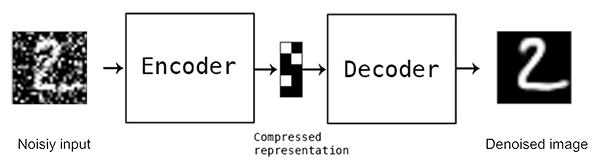

[Source](https://blog.keras.io/building-autoencoders-in-keras.html)

# Importation des packages

In [ ]:
import torch as torch
import numpy as np


from tensorflow.keras.datasets import mnist
from torchsummary import summary
import matplotlib.pyplot as plt
import cv2

# Importation des données

In [ ]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


In [ ]:
print(trainX.shape)
print(testX.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Création du bruit

Utilisez la fonction np.random.normal pour générer une matrice de taille trainX.shape selon une loi normal centrer en 0.5 avec un écart type de 0.5 pour chacune des images de notre jeu d'entraînement et de test.

Aidez-vous de la [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html).

In [ ]:
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)

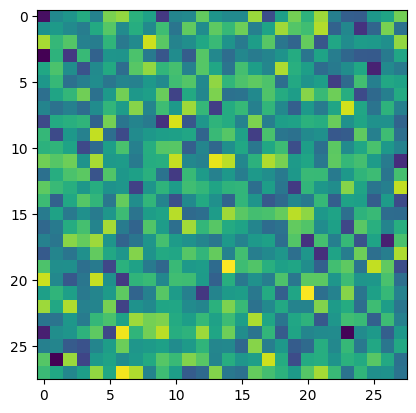

In [ ]:
plt.imshow(trainNoise[0, :, :, 0])
plt.show()

Appliquer le bruit sur les images pour créer le dataset d'entraînement et de test.

Garder les valeurs entre 0 et 1 en utilisant la fonction np.clip.

Aidez-vous de la [documentation](https://numpy.org/doc/stable/reference/generated/numpy.clip.html).

In [ ]:
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

Regarder la différence entre l'image originale et l'image bruitée.

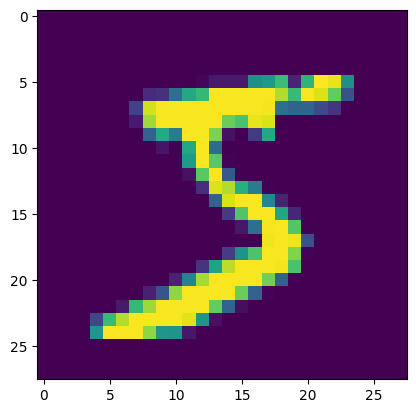

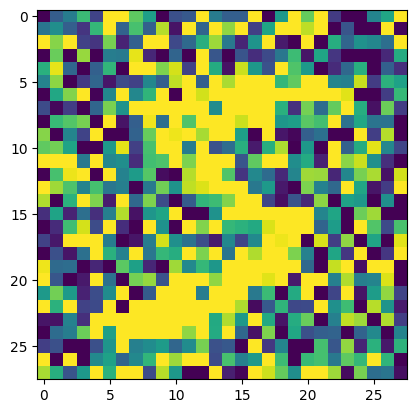

In [ ]:
plt.imshow(trainX[0, :, :, 0])
plt.show()
plt.imshow(trainXNoisy[0, :, :, 0])
plt.show()

# Création du générateur

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.img_input = x_train
        self.img_output = y_train

    def __len__(self):
        return len(self.img_output)

    def __getitem__(self, idx):
        image = self.img_input[idx, :, :, :]
        label = self.img_output[idx, :, :, :]

        return image, label

In [ ]:
x_training = CustomImageDataset(torch.from_numpy(np.transpose(np.float32(trainXNoisy), (0, 3, 1, 2))),
                                 torch.from_numpy(np.transpose(np.float32(trainX), (0, 3, 1, 2))))

In [ ]:
dataloader_train = torch.utils.data.DataLoader(x_training,
                                                batch_size=32,
                                                shuffle=True)

In [ ]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


In [ ]:
x_testing = CustomImageDataset(torch.from_numpy(np.transpose(np.float32(trainXNoisy), (0, 3, 1, 2))),
                                 torch.from_numpy(np.transpose(np.float32(trainX), (0, 3, 1, 2))))

In [ ]:
dataloader_test = torch.utils.data.DataLoader(x_testing,
                                                batch_size=32,
                                                shuffle=True)

# Initialisation de l'encodeur

Initialisation des données

In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, width, height, depth, latentDim=16):
    super().__init__()
    self.width = width
    self.height = height
    self.depth = depth
    self.latentDim = latentDim

In [ ]:
ae = AutoEncoder(28, 28, 1, 16)
print(ae.width)
print(ae.height)
print(ae.depth)
print(ae.latentDim)

28
28
1
16


Initialisation du modèle

In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, width, height, depth, latentDim=16):
    super().__init__()
    self.width = width
    self.height = height
    self.depth = depth
    self.latentDim = latentDim

    self.encoder_model()

  def encoder_model(self):

    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=5408, out_features=self.latentDim)
    )

    return self.encoder

In [ ]:
ae = AutoEncoder(28, 28, 1, 16)

In [ ]:
summary(ae.encoder, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
           Flatten-3                 [-1, 5408]               0
            Linear-4                   [-1, 16]          86,544
Total params: 86,624
Trainable params: 86,624
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.33
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


In [ ]:
for x, y in dataloader_train:

  latent_dim = ae.encoder.forward(x)
  print(latent_dim.shape)
  break

torch.Size([32, 16])


# Initialisation du décodeur

In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, width, height, depth, latentDim=16):
    super().__init__()
    self.width = width
    self.height = height
    self.depth = depth
    self.latentDim = latentDim

    self.encoder_model()
    self.decoder_model()

  def encoder_model(self):

    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=5408, out_features=self.latentDim)
    )

  def decoder_model(self):

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(in_features=self.latentDim, out_features=5408),
        torch.nn.ReLU(),
        torch.nn.Unflatten(1, (8, 26, 26)),
        torch.nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3),
        torch.nn.ReLU()
    )

In [ ]:
ae = AutoEncoder(28, 28, 1, 16)

In [ ]:
summary(ae.decoder, (16,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 5408]          91,936
              ReLU-2                 [-1, 5408]               0
         Unflatten-3            [-1, 8, 26, 26]               0
   ConvTranspose2d-4            [-1, 1, 28, 28]              73
              ReLU-5            [-1, 1, 28, 28]               0
Total params: 92,009
Trainable params: 92,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.35
Estimated Total Size (MB): 0.49
----------------------------------------------------------------


In [ ]:
for x, y in dataloader_train:
  latent_dim = ae.encoder.forward(x)
  print(latent_dim.shape)
  prediction = ae.decoder.forward(latent_dim)
  print(prediction.shape)
  break

torch.Size([32, 16])
torch.Size([32, 1, 28, 28])


# Ajout de la méthode `Forward`

In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, width, height, depth, latentDim=16):
    super().__init__()
    self.width = width
    self.height = height
    self.depth = depth
    self.latentDim = latentDim

    self.encoder_model()
    self.decoder_model()

  def encoder_model(self):

    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=5408, out_features=self.latentDim)
    )

  def decoder_model(self):

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(in_features=self.latentDim, out_features=5408),
        torch.nn.ReLU(),
        torch.nn.Unflatten(1, (8, 26, 26)),
        torch.nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3),
        torch.nn.ReLU()
    )

  def forward(self, input_data):
    latent_dim = self.encoder.forward(input_data)
    prediction = self.decoder.forward(latent_dim)

    return prediction

In [ ]:
model_ae = AutoEncoder(28, 28, 1, 16)

# Fonction d'entraînement

In [ ]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss

In [ ]:
def fit(model, optimizer, criterion, epoch, trainloader, testloader):
    epoch = epoch
    history_train_loss = []
    history_test_loss = []

    for e in range(epoch) :

      train_loss_batch = 0
      test_loss_batch = 0
      train_metric_batch = 0
      test_metric_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss = step(model, optimizer, criterion, images, labels)

        train_loss_batch += train_loss.detach().numpy()


      for images, labels in testloader:

        prediction = model.forward(images)

        test_loss = criterion(prediction, labels)

        test_loss_batch += test_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)
      test_loss_batch /= len(testloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)
      history_test_loss = np.append(history_test_loss, test_loss_batch)

      print('train_loss : '+str(np.squeeze(train_loss_batch))+ ' test_loss : '+str(np.squeeze(test_loss_batch)))
      print('-------------------------------------------------------------------------------------------------')

    return model, history_train_loss, history_test_loss

# Entraînement du modèle

Initialisez `criterion` avec la fonction `L1Loss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_ae.parameters(), lr=0.001)

In [ ]:
epoch = 5

In [ ]:
model, history_train_loss, history_test_loss = fit(model_ae,
                                                   optimizer,
                                                   criterion,
                                                   epoch,
                                                   dataloader_train,
                                                   dataloader_test)

train_loss : 0.0029655195490767556 test_loss : 0.002017559794895351
-------------------------------------------------------------------------------------------------
train_loss : 0.001839152987425526 test_loss : 0.001708043139303724
-------------------------------------------------------------------------------------------------
train_loss : 0.0016788279077659051 test_loss : 0.0016128163478026788
-------------------------------------------------------------------------------------------------
train_loss : 0.0016123366891716917 test_loss : 0.0015664845543603102
-------------------------------------------------------------------------------------------------
train_loss : 0.0015758266049126783 test_loss : 0.0015307757868121068
-------------------------------------------------------------------------------------------------


torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


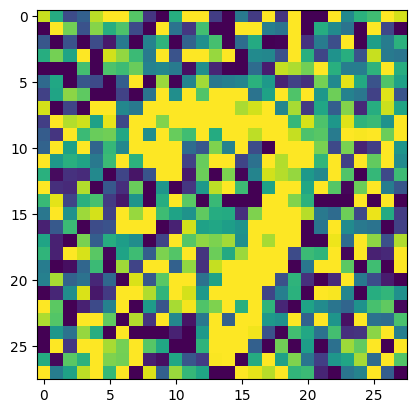

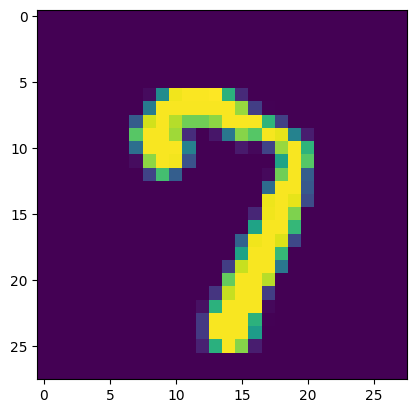

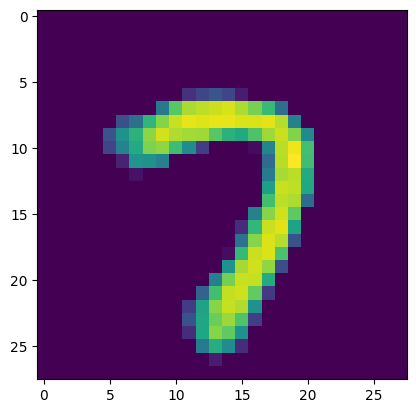

In [ ]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)

  plt.imshow(x[0, 0, :, :])
  plt.show()

  plt.imshow(y[0, 0, :, :])
  plt.show()

  pred = model_ae.forward(x[:1, :, :, :]).detach().numpy()
  plt.imshow(pred[0, 0, :, :])
  plt.show()
  break